In [1]:
# import rozneho potrebneho...

%load_ext autoreload
%autoreload

%matplotlib nbagg

import numpy as np
from scipy.integrate import odeint

import sys
sys.path.append('./misc/')

from figFcns import *

# Úvod

Adaptívne riadenie 

* súčasť pokročilých metód automatického riadenia
* motivácia: riadenie systémov, ktorých parametre sú neznáme a/alebo sa menia v čase
    - v začiatkoch najmä lietadlá, rakety atď...
    - v súčasnosti asi čokoľvek


<hr />

* Adaptívne riadenie zahŕňa:
    - Gain scheduling  <br/><br/>  
    
    - Samonastavujúci sa regulátor <br/><i>(priebežná identifikácia parametrov modelu, získa sa model, následne aplikácia metódy návrhu regulátora...)</i><br/><br/>
    
    - Gradientné metódy pre „update“ predmetných parametrov <br/><i>(vo všeobecnosti však stále ide o priebežnú identifikáciu parametrov (riadeného alebo riadiaceho systému)</i><br/><br/>
    
    - Ucelené prístupy k zostaveniu adaptívneho riadiaceho systému - zákon riadenia, zákon adaptácie a ďalšie súčasti riadiaceho systému.  <br/>
    
    Tieto prístupy presne definujú predpoklady nevyhnutné pre použitie daného adapt. riadiaceho systému. Systém nie je schopný sa adaptovať pri akýchoľvek podmienkach. Niektoré informácie (napr. štruktúra riadeného sys., vlastnosti príkazov pre riadený systém (referenčné signály, žiadané hodnoty), atp...) musia byť známe/splnené...
    

Teória AR poskytuje nástroje a návody ako postupovať, ako premýšlať, ak je potrebné zostaviť adaptívny systém - v širšom slova zmysle. Výsledky/skúsenosti sú použiteľné samozrejme aj v oblastiach ako učiace sa systémy (machine learning, „ktovieaký“ learning) a iné v súčasnosti veľmi populárne a rozvíjajúce sa oblasti.
    
Teória AR ukazuje čo by bolo možné dosiahnuť pri daných predpokladoch a známych dostupných údajoch. Takáto skúsenosť je potom jednoznačne využiteľná aj v prípade keď sa predpokladá, že nie je známe prakticky vôbec nič...  To je jeden z hlavných dôvodov pre štúdium teórie klasického Adaptívneho riadenia.

## Témy v rámci predmetu


* <b>Samonastavujúci sa regulátor</b> (nepriame adaptívne riadenie)
    - rekurzívna MNŠ (aj so zabúdaním)
    
    
* <b>Stabilita podľa Lyapunova</b>
    - nie je to však primárna téma, v podstate stačí poznať spôsob ako použiť vyplívajúce nástroje, nie teóriu, ktorá k nim vedie


* <b>MIT pravidlo - gradientný prístup k návrhu zákona adaptácie</b> (pri priamom adaptívnom riadení)


* <b>Adaptívne riadenie s referenčným modelom</b>
    - pri predpoklade dostupnosti stavového vektora riadeného systému pre spätnú väzbu
    - pri dostupnosti len vstupnej a výstupnej veličiny systému (nie stavu)
        - realizácia závislá od relatívneho stupňa riadeného systému

## Odporúčaná literatúra

P. Ioannou and J. Sun. Robust Adaptive Control. Prentice Hall, Inc, 1996.

dostupné tu: http://www-bcf.usc.edu/~ioannou/RobustAdaptiveBook95pdf/Robust_Adaptive_Control.pdf

(ignorujme, že to má vyše 800 strán :)

# Adaptívna stabilizácia

Príklad veľmi jednoduchého, avšak veľmi názorného adaptívneho riadiaceho systému.

Uvažujme riadený systém v tvare
\begin{equation}
	\dot{x} = a\, x + u
\end{equation}

Cieľ riadenia možno vyjadriť ako:
\begin{equation} 
	\dot{x} = -a_m\, x  \qquad a_m > 0 \quad \text{dané požiadavkami...}
\end{equation}


Regulátor:
\begin{equation} 
	u = -k\, x \qquad k > \left| a \right|
\end{equation}
spĺňa cieľ riadenia:
\begin{equation} 
\dot{x} = a\, x + \left( -k\, x \right) = \left(a-k\right)\,x
\end{equation}
(uvedené je rovnica URO)


Pre ktoré $a$ je systém stabilný a pre ktoré $a$ je nestabilný? 

### Simulácia č. 1

Vyskúšajme: zvoľme konkrétnu hodnotu parametra $a$ z nájdeného intervalu tak aby riadený systém bol <b>stabilný</b>. Nech začiatočný stav je $x(0) = 1$ a $u(t)=0$

#### „Simulačná schéma“:

Funkcia realizujúca potrebné diferenciálne rovnice (v tomto prípade rovnice riadeného systému):

In [2]:
def fcn_difRovnice_01(x, t, param_a):

    a = param_a
    b = 1

    u = 0

    dotx = a*x + b*u

    return dotx

Samotná „simulačná schéma“ (ak je potrebné niečo zmeniť, nastaviť atď, v rámci numerickej simulácie, tak tu...)

In [3]:
def fcn_simSch_01(t_start, t_final, T_s, param_a):

    #-----------------------------------------
    t_log = np.arange(sim_t_start, sim_t_final+sim_T_s, sim_T_s)

    #-----------------------------------------
    x_0 = 1

    #-----------------------------------------
    odeOut = odeint(fcn_difRovnice_01,
                    x_0,
                    t_log,
                    args=(param_a,)
                    )

    return [t_log.reshape(-1,1), odeOut]

In [4]:
param_a = -2

# Nastavenia simulacie

sim_t_start = 0
sim_t_final = 5
sim_T_s = 0.1

# Simulacia

t_log, x_log, = fcn_simSch_01(sim_t_start, sim_t_final, sim_T_s, param_a)

<IPython.core.display.Javascript object>


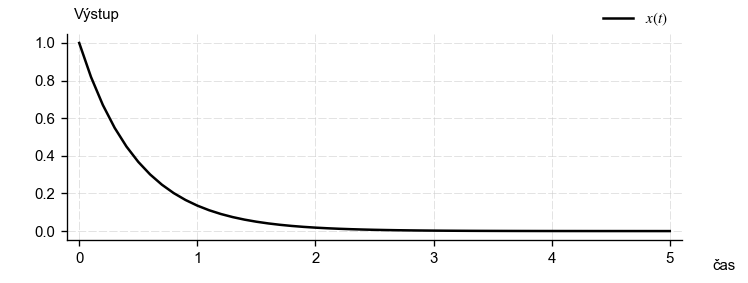

In [5]:
# Obrazok
figNameNum = 1
figNamePrefix = 'cv00_fig_'

figPlotParam = fcnDefaultFigSize(6, 0.09, 0.88, 0.15, 0.4, 13)
fig = plt.figure(figNameNum, figsize=figPlotParam[0:2])

subPlots = gridspec.GridSpec(1, 1, )

#------------------
ax0 = plt.subplot(subPlots[0])

ax0.set_title(u'Výstup', x=0.01, y=1.02, ha='left')

ax0.plot(t_log, x_log[:,0],
         '-k',
         label=u'$x(t)$',
         )

#------------------
for ax in fig.get_axes():
    ax.set_xlabel(u'čas', x=1.05, ha='left', va='bottom')

#------------------
fcnDefaultLayoutAdj(fig, figPlotParam[2], figPlotParam[3], figPlotParam[4], figPlotParam[5])

for ax in fig.get_axes():
    fcnDefaultAxisStyle(ax)
    handles_ax, labels_ax = ax.get_legend_handles_labels()

    if ax == ax0:
        ax.legend(handles_ax, labels_ax, loc=1, bbox_to_anchor=(0.98, 1.12))

#------------------

plt.savefig('fig/' + figNamePrefix + '{}'.format(figNameNum) +'.png', dpi=200)
plt.savefig('fig/' + figNamePrefix + '{}'.format(figNameNum) +'.pdf')

### Simulácia č. 2

Nech $x(0) = 1$, systém nech je <b>nestabilný</b>.

In [6]:
param_a = 1

# Nastavenia simulacie

sim_t_start = 0
sim_t_final = 5
sim_T_s = 0.1

# Simulacia

t_log, x_log, = fcn_simSch_01(sim_t_start, sim_t_final, sim_T_s, param_a)

<IPython.core.display.Javascript object>


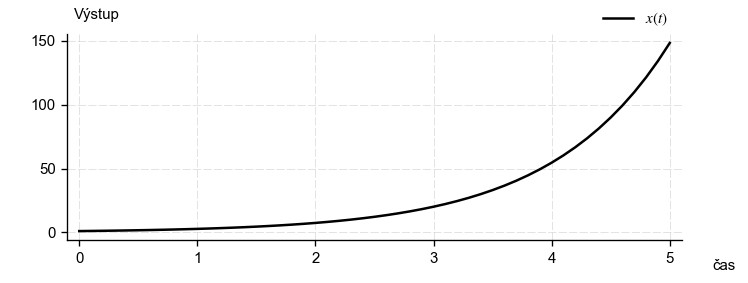

In [7]:
# Obrazok
figNameNum = 2
figNamePrefix = 'cv00_fig_'

figPlotParam = fcnDefaultFigSize(6, 0.09, 0.88, 0.15, 0.4, 13)
fig = plt.figure(figNameNum, figsize=figPlotParam[0:2])

subPlots = gridspec.GridSpec(1, 1, )

#------------------
ax0 = plt.subplot(subPlots[0])

ax0.set_title(u'Výstup', x=0.01, y=1.02, ha='left')

ax0.plot(t_log, x_log[:,0],
         '-k', 
         label = u'$x(t)$'
         )

#------------------
for ax in fig.get_axes():
    ax.set_xlabel(u'čas', x=1.05, ha='left', va='bottom')

#------------------
fcnDefaultLayoutAdj(fig, figPlotParam[2], figPlotParam[3], figPlotParam[4], figPlotParam[5])

for ax in fig.get_axes():
    fcnDefaultAxisStyle(ax)
    handles_ax, labels_ax = ax.get_legend_handles_labels()

    if ax == ax0:
        ax.legend(handles_ax, labels_ax, loc=1, bbox_to_anchor=(0.98, 1.12))

#------------------

plt.savefig('fig/' + figNamePrefix + '{}'.format(figNameNum) +'.png', dpi=200)
plt.savefig('fig/' + figNamePrefix + '{}'.format(figNameNum) +'.pdf')

### Simulácia č. 3

Pridajme k riadenému systému regulátor daný nasledovne:
\begin{equation} 
	u = -k\, x \qquad k > \left| a \right|
\end{equation}
a overme, že URO je stabilný.

In [8]:
def fcn_difRovnice_02(x, t, param_a, param_k):

    a = param_a
    b = 1

    k = param_k

    u = -k*x

    dotx = a*x + b*u

    return dotx


def fcn_simSch_02(t_start, t_final, T_s, param_a):

    #-----------------------------------------
    t_log = np.arange(sim_t_start, sim_t_final+sim_T_s, sim_T_s)

    #-----------------------------------------
    x_0 = 1

    #-----------------------------------------
    odeOut = odeint(fcn_difRovnice_02,
                    x_0,
                    t_log,
                    args=(param_a, param_k)
                    )

    return [t_log.reshape(-1,1), odeOut]

In [9]:
param_k = np.abs(param_a) + 0.1

# Nastavenia simulacie

sim_t_start = 0
sim_t_final = 50
sim_T_s = 0.1

# Simulacia

t_log, x_log, = fcn_simSch_02(sim_t_start, sim_t_final, sim_T_s, param_a)

<IPython.core.display.Javascript object>


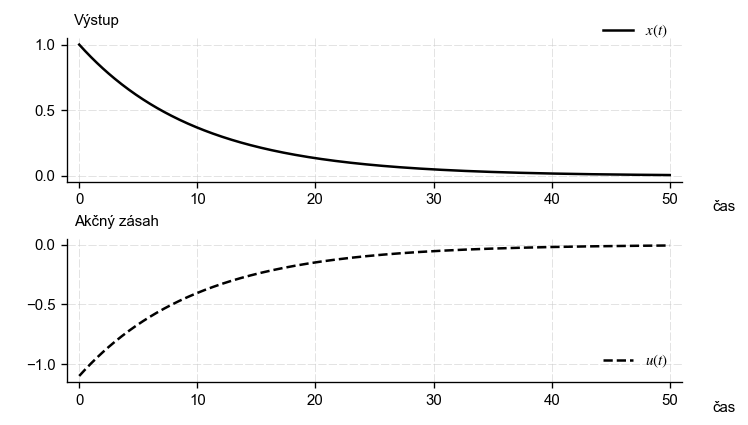

In [10]:
# Obrazok
figNameNum = 3
figNamePrefix = 'cv00_fig_'

figPlotParam = fcnDefaultFigSize(9, 0.09, 0.91, 0.1, 0.4, 13)
fig = plt.figure(figNameNum, figsize=figPlotParam[0:2])

subPlots = gridspec.GridSpec(2, 1, )

#------------------
ax0 = plt.subplot(subPlots[0])

ax0.set_title(u'Výstup', x=0.01, y=1.02, ha='left')

ax0.plot(t_log, x_log[:,0],
         '-k',
         label = u'$x(t)$'
         )

#------------------
ax1 = plt.subplot(subPlots[1])

ax1.set_title(u'Akčný zásah', x=0.01, y=1.02, ha='left')

ax1.plot(t_log, -param_k*x_log[:,0],
         '--k',
         label = u'$u(t)$'
         )

#------------------
for ax in fig.get_axes():
    ax.set_xlabel(u'čas', x=1.05, ha='left', va='bottom')

#------------------
fcnDefaultLayoutAdj(fig, figPlotParam[2], figPlotParam[3], figPlotParam[4], figPlotParam[5])

for ax in fig.get_axes():
    fcnDefaultAxisStyle(ax)
    handles_ax, labels_ax = ax.get_legend_handles_labels()

    if ax == ax0:
        ax.legend(handles_ax, labels_ax, loc=1, bbox_to_anchor=(0.98, 1.12))
    elif ax == ax1:
        ax.legend(handles_ax, labels_ax, loc=1, bbox_to_anchor=(0.98, 0.22))

#------------------

plt.savefig('fig/' + figNamePrefix + '{}'.format(figNameNum) +'.png', dpi=200)
plt.savefig('fig/' + figNamePrefix + '{}'.format(figNameNum) +'.pdf')

### Simulácia č. 4

Pridajme k riadenému systému regulátor daný nasledovne:
\begin{equation} 
	u = -k\, x; \qquad \dot{k} = x^2
\end{equation}
Simuláciou vyšetrime stabilitu URO.

In [11]:
def fcn_difRovnice_04(x, t, param_a):

    x, k = x

    a = param_a
    b = 1

    dotk = x**2

    u = -k*x

    dotx = a*x + b*u

    return [dotx, dotk]



def fcn_simSch_04(t_start, t_final, T_s, param_a):

    #-----------------------------------------
    t_log = np.arange(sim_t_start, sim_t_final+sim_T_s, sim_T_s)

    #-----------------------------------------
    x_0 = [1, 0]

    #-----------------------------------------
    odeOut = odeint(fcn_difRovnice_04,
                    x_0,
                    t_log,
                    args=(param_a,)
                    )

    return [t_log.reshape(-1,1), odeOut]

<IPython.core.display.Javascript object>


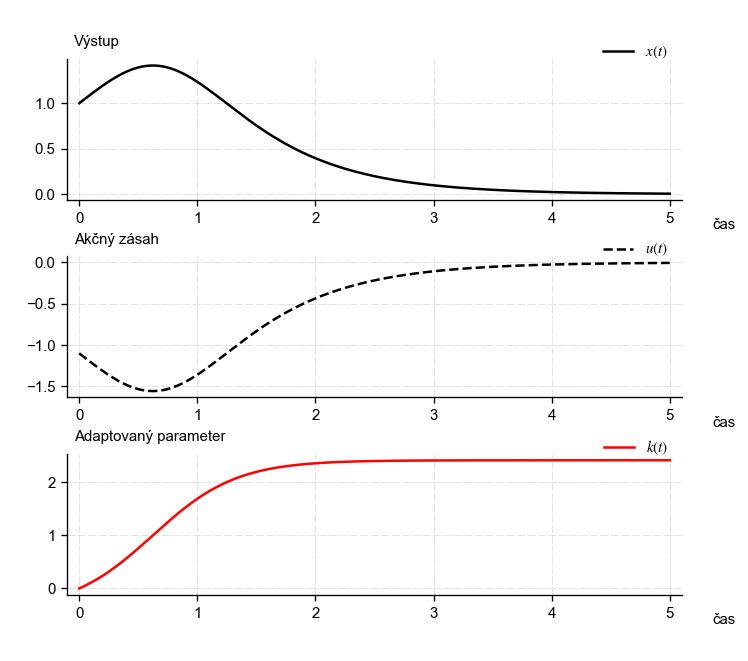

In [12]:
param_a = 1

# Nastavenia simulacie

sim_t_start = 0
sim_t_final = 5
sim_T_s = 0.01

# Simulacia

t_log, x_log, = fcn_simSch_04(sim_t_start, sim_t_final, sim_T_s, param_a)




# Obrazok
figNameNum = 4
figNamePrefix = 'cv00_fig_'

figPlotParam = fcnDefaultFigSize(14, 0.09, 0.91, 0.1, 0.4, 13)
fig = plt.figure(figNameNum, figsize=figPlotParam[0:2])

subPlots = gridspec.GridSpec(3, 1, )

#------------------
ax0 = plt.subplot(subPlots[0])

ax0.set_title(u'Výstup', x=0.01, y=1.02, ha='left')

ax0.plot(t_log, x_log[:,0],
         '-k',
         label = u'$x(t)$'
         )

#------------------
ax1 = plt.subplot(subPlots[1])

ax1.set_title(u'Akčný zásah', x=0.01, y=1.02, ha='left')

ax1.plot(t_log, -param_k*x_log[:,0],
         '--k',
         label = u'$u(t)$'
         )

#------------------
ax2 = plt.subplot(subPlots[2])

ax2.set_title(u'Adaptovaný parameter', x=0.01, y=1.02, ha='left')

ax2.plot(t_log, x_log[:,1],
         '-r',
         label = u'$k(t)$'
         )

#------------------
for ax in fig.get_axes():
    ax.set_xlabel(u'čas', x=1.05, ha='left', va='bottom')


#------------------
fcnDefaultLayoutAdj(fig, figPlotParam[2], figPlotParam[3], figPlotParam[4], figPlotParam[5])

for ax in fig.get_axes():
    fcnDefaultAxisStyle(ax)
    handles_ax, labels_ax = ax.get_legend_handles_labels()

    if ax == ax0:
        ax.legend(handles_ax, labels_ax, loc=1, bbox_to_anchor=(0.98, 1.12))
    else:
        ax.legend(handles_ax, labels_ax, loc=1, bbox_to_anchor=(0.98, 1.12))

#------------------

plt.savefig('fig/' + figNamePrefix + '{}'.format(figNameNum) +'.png', dpi=200)
plt.savefig('fig/' + figNamePrefix + '{}'.format(figNameNum) +'.pdf')